<a href="https://colab.research.google.com/github/umayasiriwardhana/Machine-Learning-Project/blob/main/Predict_The_Stock_Market_With_Machine_Learning_And_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import os

In [5]:
if os.path.exists(r"C:\Users\umaya\OneDrive\Desktop\sp500.csv"):
    sp500 = pd.read_csv(r"C:\Users\umaya\OneDrive\Desktop\sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv(r"C:\Users\umaya\OneDrive\Desktop\sp500.csv")


In [7]:
sp500.index = pd.to_datetime(sp500.index, utc=True)

In [8]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-03 04:00:00+00:00,5698.189941,5718.779785,5677.370117,5699.939941,3597450000,0.0,0.0
2024-10-04 04:00:00+00:00,5737.479980,5753.209961,5702.830078,5751.069824,3479400000,0.0,0.0
2024-10-07 04:00:00+00:00,5737.799805,5739.339844,5686.850098,5695.939941,3637790000,0.0,0.0


<Axes: xlabel='Date'>

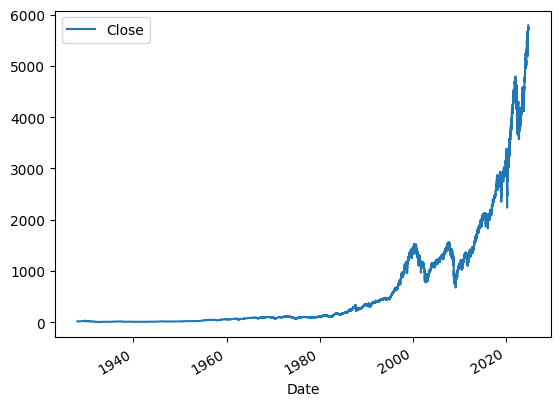

In [9]:
sp500.plot.line(y="Close", use_index=True)

In [10]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [11]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [12]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [13]:
sp500 = sp500.loc["1990-01-01":].copy()

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [18]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

<Axes: xlabel='Date'>

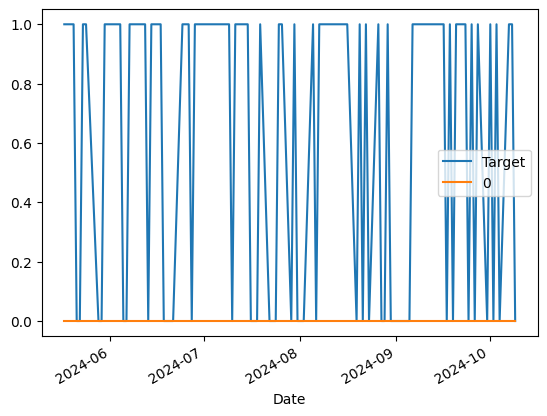

In [19]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [20]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [21]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [22]:
predictions = backtest(sp500, model, predictors)

In [24]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3657
1,2603


In [25]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5290049942374183

In [26]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535783
0,0.464217


In [28]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [23]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [29]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 05:00:00+00:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 05:00:00+00:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 05:00:00+00:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 05:00:00+00:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 05:00:00+00:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03 04:00:00+00:00,5698.189941,5718.779785,5677.370117,5699.939941,3597450000,5751.069824,1,0.999159,1.0,0.995836,2.0,1.026929,33.0,1.120948,147.0,1.300273,526.0
2024-10-04 04:00:00+00:00,5737.479980,5753.209961,5702.830078,5751.069824,3479400000,5695.939941,0,1.004465,1.0,1.004316,3.0,1.035623,34.0,1.129721,147.0,1.311267,527.0
2024-10-07 04:00:00+00:00,5737.799805,5739.339844,5686.850098,5695.939941,3637790000,5751.129883,1,0.995184,1.0,0.997005,2.0,1.025448,33.0,1.117697,146.0,1.298044,527.0


In [30]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
predictions = backtest(sp500, model, new_predictors)

In [33]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,5231
1.0,1029


In [34]:
precision_score(predictions["Target"], predictions["Predictions"])

0.54421768707483

In [35]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535783
0,0.464217


In [36]:
predictions

,Target,Predictions
Date,,
1999-11-22 05:00:00+00:00,0,0.0
1999-11-23 05:00:00+00:00,1,0.0
1999-11-24 05:00:00+00:00,0,0.0
1999-11-26 05:00:00+00:00,0,1.0
1999-11-29 05:00:00+00:00,0,0.0
...,...,...
2024-10-03 04:00:00+00:00,1,0.0
2024-10-04 04:00:00+00:00,0,1.0
2024-10-07 04:00:00+00:00,1,0.0
